In [1]:
# Parameters
# Refer to injected parameters for any run.ipynb (similar cell below)
fname = 'MiSeqRun2-FKS2-HS2_variant_data_merge.tsv' # All MiSeqRun2
strain = 'BY4741'
locus = 'FKS2-HS2'
pool_type = 'ortho'

min_input_readcount_high = 10
min_input_readcount_mid = 3

# Notebook to assess diversity from initial libraries sequenced in pre-runs

## Import libraries

In [2]:
import os
import glob
import re
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
from upsetplot import from_indicators
from upsetplot import UpSet

## Specify paths

In [3]:
metadata_path = '../data/'
variantdata_path = '../preruns/'
DMSdata_path = '../processed_data/'
orthoTAXpath = '../orthologs/fks1_dataframe.csv'
codon_table_path = '../data/general_use/ScerevisiaeTAXID559292_Cocoputs_codon_table.csv'
graph_outpath = '../diagnostics_graphs/'

## Analysis

In [4]:
f = variantdata_path+fname

### Read dataframe

In [5]:
df = pd.read_csv(f, sep='\t', header=0, dtype={'WT': 'boolean'}) # Boolean type supports missing data, helps pandas interpret column content
df

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,inputD1_e1_s0_bNA_count,inputD2_e2_s0_bNA_count,...,outputD6_e6_s1_b1_count,outputD7_e7_s1_b1_count,outputD8_e8_s1_b1_count,outputO1_e9_s1_b1_count,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
0,aaaaaggtgagacgttatacactc,KKVRRYTL,<NA>,False,False,4.0,2.0,2.0,0,1,...,0,0,0,0,True,False,True,True,False,False
1,aaaatggattaaaagatgtattatt,KMD*KMYY,<NA>,True,False,NaN,NaN,NaN,0,0,...,0,0,0,1,True,True,True,NaN,NaN,NaN
2,aaacggattaaaagatgtattatt,KRIKRCII,<NA>,False,False,13.0,7.0,8.0,0,0,...,0,0,0,1,True,False,True,True,False,False
3,aaaggtgagacgtctgacactc,KGETSDT,<NA>,False,False,NaN,NaN,NaN,0,0,...,1,0,0,0,True,True,True,NaN,NaN,NaN
4,aaaggtgagacgttatgggctc,KGETLWA,<NA>,False,False,NaN,NaN,NaN,0,1,...,0,0,0,0,True,True,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137668,ttttttgtgagacgttatactctc,FFVRRYTL,<NA>,False,False,5.0,2.0,3.0,0,0,...,1,0,0,0,True,False,True,True,False,False
137669,ttttttgtgagacgttatgtggaag,FFVRRYVE,<NA>,False,False,NaN,NaN,NaN,0,0,...,0,0,0,0,True,True,True,NaN,NaN,NaN
137670,ttttttgtgagacgttattatctc,FFVRRYYL,<NA>,False,False,7.0,3.0,3.0,1,0,...,0,0,0,0,True,False,True,True,False,False
137671,tttttttgtgagacgttatacactc,FFCETLYT,<NA>,False,False,NaN,NaN,NaN,1,0,...,0,0,0,0,True,True,True,NaN,NaN,NaN


In [6]:
raw_cols = [x for x in df.columns if 'inputO' in x]
conditions = [x.split('_')[0] for x in raw_cols]
df.rename(columns=dict(zip(raw_cols, conditions)), inplace=True)
df.head(1)

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,inputD1_e1_s0_bNA_count,inputD2_e2_s0_bNA_count,...,outputD6_e6_s1_b1_count,outputD7_e7_s1_b1_count,outputD8_e8_s1_b1_count,outputO1_e9_s1_b1_count,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
0,aaaaaggtgagacgttatacactc,KKVRRYTL,<NA>,False,False,4.0,2.0,2.0,0,1,...,0,0,0,0,True,False,True,True,False,False


In [7]:
# Extract WT sequences (nucleotide and protein)
wtseq = df.loc[df.WT==True, 'nt_seq'].values[0]
wtaa = df.loc[df.WT==True, 'aa_seq'].values[0]
print(f'WT (nt): {wtseq} | (aa): {wtaa}')

WT (nt): gattgggtgagacgttatacactc | (aa): DWVRRYTL


### Mean readcount per variant (raw data)

This matrix shows the average readcount per unique nucleotide sequence per number of mutated codons across samples.

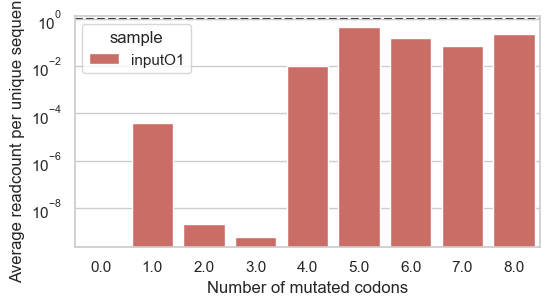

In [8]:
# Purge graph space
sns.set(rc = {'figure.figsize':(6,3)})
sns.set_theme(style='whitegrid')
f, ax = plt.subplots()

count_per_mut_codon = df.groupby('Nmut_codons')[conditions].count()
mean_rc_per_variant = df.groupby('Nmut_codons')[conditions].mean() / count_per_mut_codon
mean_rc_per_variant.reset_index(inplace=True)
mean_rc_long = mean_rc_per_variant.melt(id_vars=['Nmut_codons'], value_vars=conditions, var_name='sample')
sns.barplot(mean_rc_long, x='Nmut_codons',y='value',hue='sample',palette='hls')
plt.yscale('log')
plt.ylabel('Average readcount per unique sequence')
plt.xlabel('Number of mutated codons')
plt.axhline(y=1, linestyle='--', c='k', zorder=-10)

### Overrepresented variants (raw data)

The table below shows the 5 most represented sequences (mean readcount across samples) in % read depth per sample.

In [9]:
overrep_index = df[conditions].mean(axis=1).sort_values(ascending=False).index[:5]
overrep = 100*round(df.iloc[overrep_index][conditions] / df[conditions].sum(axis=0), 4)
pd.concat([overrep, df.iloc[overrep_index][['nt_seq', 'aa_seq', 'Nmut_codons']]], axis=1)

,inputO1,nt_seq,aa_seq,Nmut_codons
61587,2.67,gattggattagaagatgtgttttg,DWIRRCVL,5.0
62331,2.41,gattggatttatagatgtgttttg,DWIYRCVL,6.0
62166,2.35,gattggattgatagatgtgttttg,DWIDRCVL,6.0
97569,2.27,gattgggttgctagatctattgct,DWVARSIA,6.0
60182,2.27,gattggatgagacaatctttgttg,DWMRQSLL,5.0


### Calculate % read depth per sample corresponding to variants with no indels + read count above threshold

In [10]:
# Sum all reads for each sample
# Check proportion that corresponds to variants with no indels
rcNoIndel = df[conditions].sum(axis=0).to_frame('Total_reads')
rcNoIndel['Reads_no_indels'] = df[df.indel == False][conditions].sum(axis=0)
rcNoIndel['Reads_no_indels_%'] = 100*round(rcNoIndel['Reads_no_indels']/rcNoIndel['Total_reads'], 3)

# Check proportion that corresponds to variants with a read count >= 3 in any sample
rcNoIndel['No_indels_acceptable_RC'] = df[((df[conditions] > 2).any(axis=1)) & (df.indel == False)][conditions].sum(axis=0)
rcNoIndel['Acceptable_RC_over_no_indels_%'] = 100*round(rcNoIndel['No_indels_acceptable_RC']/rcNoIndel['Reads_no_indels'], 3)

rcNoIndel

,Total_reads,Reads_no_indels,Reads_no_indels_%,No_indels_acceptable_RC,Acceptable_RC_over_no_indels_%
inputO1,486006,480267,98.8,477821,99.5


#### ⚠️ **Filtering step** ⚠️ - Discard variants with indels

In [11]:
# Keeping only variants with no indels
df.drop(df[df.indel].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,inputD1_e1_s0_bNA_count,inputD2_e2_s0_bNA_count,...,outputD6_e6_s1_b1_count,outputD7_e7_s1_b1_count,outputD8_e8_s1_b1_count,outputO1_e9_s1_b1_count,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
0,aaaaaggtgagacgttatacactc,KKVRRYTL,<NA>,False,False,4.0,2.0,2.0,0,1,...,0,0,0,0,True,False,True,True,False,False
1,aaacggattaaaagatgtattatt,KRIKRCII,<NA>,False,False,13.0,7.0,8.0,0,0,...,0,0,0,1,True,False,True,True,False,False
2,aaatagattaaaagatgtattatt,K*IKRCII,<NA>,True,False,13.0,7.0,8.0,0,0,...,0,0,0,3,True,False,True,True,False,False
3,aaatgaattaaaagatgtattatt,K*IKRCII,<NA>,True,False,13.0,7.0,8.0,0,0,...,0,0,0,2,True,False,True,True,False,False
4,aaatgcattaaaagatgtattatt,KCIKRCII,<NA>,False,False,13.0,7.0,8.0,0,0,...,0,0,0,1,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94361,ttttttgtgagacgttatacactc,FFVRRYTL,<NA>,False,False,4.0,2.0,2.0,25,13,...,18,21,22,0,True,False,True,True,False,False
94362,ttttttgtgagacgttatacatag,FFVRRYT*,<NA>,True,False,7.0,3.0,3.0,0,1,...,0,0,0,0,True,False,True,True,False,False
94363,ttttttgtgagacgttatactctc,FFVRRYTL,<NA>,False,False,5.0,2.0,3.0,0,0,...,1,0,0,0,True,False,True,True,False,False
94364,ttttttgtgagacgttattatctc,FFVRRYYL,<NA>,False,False,7.0,3.0,3.0,1,0,...,0,0,0,0,True,False,True,True,False,False


#### ⚠️ **Filtering step** ⚠️ - Keep only variants with at least 3 reads in at least 1 input replicate

In [12]:
inputRCdf = df[(df[conditions] > 2).any(axis=1)]
inputRCdf

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,inputD1_e1_s0_bNA_count,inputD2_e2_s0_bNA_count,...,outputD6_e6_s1_b1_count,outputD7_e7_s1_b1_count,outputD8_e8_s1_b1_count,outputO1_e9_s1_b1_count,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
2,aaatagattaaaagatgtattatt,K*IKRCII,<NA>,True,False,13.0,7.0,8.0,0,0,...,0,0,0,3,True,False,True,True,False,False
11,aaatggattaaaagaactattatt,KWIKRTII,<NA>,False,False,13.0,6.0,7.0,0,0,...,0,0,0,4,True,False,True,True,False,False
14,aaatggattaaaagatctattatt,KWIKRSII,<NA>,False,False,12.0,6.0,7.0,0,0,...,0,0,0,10,True,False,True,True,False,False
23,aaatggattaaaagatgtattatg,KWIKRCIM,<NA>,False,False,12.0,6.0,7.0,0,0,...,0,0,0,6,True,False,True,True,False,False
24,aaatggattaaaagatgtattatt,KWIKRCII,<NA>,False,False,12.0,6.0,7.0,0,0,...,0,0,0,5333,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91996,ttgtggattaaaagatctattatt,LWIKRSII,<NA>,False,False,13.0,6.0,7.0,0,0,...,0,0,0,11,True,False,True,True,False,False
91999,ttgtggattaaaagatgtattatt,LWIKRCII,<NA>,False,False,13.0,6.0,7.0,0,0,...,0,0,0,9,True,False,True,True,False,False
92000,ttgtggattaaaagatgtattgtt,LWIKRCIV,<NA>,False,False,13.0,6.0,7.0,0,0,...,0,0,0,4,True,False,True,True,False,False
92005,ttgtggattaaaataactattatt,LWIKITII,<NA>,False,False,15.0,7.0,7.0,0,0,...,0,0,0,4,True,False,True,True,False,False


### Label variants with confidence score (related to readcount)

In [13]:
def get_confidence_score(g, thresh_high, thresh_mid):
    # The read count in all input replicates is parsed to label each variant with a confidence score
    # Score is an integer for easy aggregation of synonymous codons
    if (g >= thresh_high).all():
        return 1 # high confidence score
    elif (g > thresh_mid).any():
        return 2 # medium confidence score
    else:
        return 3 # low confidence score

In [14]:
pd.set_option('mode.chained_assignment', None) # Disable settingWithCopy warning
inputRCdf['confidence_score'] = inputRCdf[conditions].apply(lambda row: get_confidence_score(row, min_input_readcount_high, min_input_readcount_mid), axis=1)
inputRCdf

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,inputD1_e1_s0_bNA_count,inputD2_e2_s0_bNA_count,...,outputD7_e7_s1_b1_count,outputD8_e8_s1_b1_count,outputO1_e9_s1_b1_count,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions,confidence_score
2,aaatagattaaaagatgtattatt,K*IKRCII,<NA>,True,False,13.0,7.0,8.0,0,0,...,0,0,3,True,False,True,True,False,False,3
11,aaatggattaaaagaactattatt,KWIKRTII,<NA>,False,False,13.0,6.0,7.0,0,0,...,0,0,4,True,False,True,True,False,False,2
14,aaatggattaaaagatctattatt,KWIKRSII,<NA>,False,False,12.0,6.0,7.0,0,0,...,0,0,10,True,False,True,True,False,False,1
23,aaatggattaaaagatgtattatg,KWIKRCIM,<NA>,False,False,12.0,6.0,7.0,0,0,...,0,0,6,True,False,True,True,False,False,2
24,aaatggattaaaagatgtattatt,KWIKRCII,<NA>,False,False,12.0,6.0,7.0,0,0,...,0,0,5333,True,False,True,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91996,ttgtggattaaaagatctattatt,LWIKRSII,<NA>,False,False,13.0,6.0,7.0,0,0,...,0,0,11,True,False,True,True,False,False,1
91999,ttgtggattaaaagatgtattatt,LWIKRCII,<NA>,False,False,13.0,6.0,7.0,0,0,...,0,0,9,True,False,True,True,False,False,2
92000,ttgtggattaaaagatgtattgtt,LWIKRCIV,<NA>,False,False,13.0,6.0,7.0,0,0,...,0,0,4,True,False,True,True,False,False,2
92005,ttgtggattaaaataactattatt,LWIKITII,<NA>,False,False,15.0,7.0,7.0,0,0,...,0,0,4,True,False,True,True,False,False,2


### Merge with dataframe of expected variants

In [15]:
# Dataframe containing all expected mutants for the different libraries (single, double, ortholog) is imported
# /!\ Important to note that I did not actually separate by type of library /!\
# "Double" mutants do not include single mutants
# "Ortho" are standalone (double mutants in orthologous sequences are duplicated in "double" and "ortho" seq types)
source = metadata_path+locus+f'/{locus}_var_df.csv'
vardf = pd.read_csv(source, header=0, index_col=0)
vardf

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination
0,WT,gattgggtgagacgttatacactc,NaN,NaN,NaN,NaN
1,single,ttttgggtgagacgttatacactc,0.0,ttt,1.0,NaN
2,single,ttgtgggtgagacgttatacactc,0.0,ttg,1.0,NaN
3,single,ctttgggtgagacgttatacactc,0.0,ctt,1.0,NaN
4,single,ctgtgggtgagacgttatacactc,0.0,ctg,1.0,NaN
...,...,...,...,...,...,...
55760,ortho,gattgggttaatagatgtattatt,3.0,aat,2.0,NaN
55761,ortho,gattgggttaatagatgtattatt,4.0,aga,3.0,NaN
55762,ortho,gattgggttaatagatgtattatt,5.0,tgt,4.0,NaN
55763,ortho,gattgggttaatagatgtattatt,6.0,att,5.0,NaN


#### ⚠️ **Filtering step** ⚠️ - Keep only mutants corresponding to pool_type

In [16]:
# Depending on the type of pool (single or double), expected variants are filtered
# The dictionary specifies which sequence types must be kept
keep_seq_type = {'ortho':['WT','ortho']}
var_filtered_df = vardf[vardf.seq_type.isin(keep_seq_type[pool_type])]
len(var_filtered_df)

390

In [17]:
# Here we need to translate expected variants to aa,.. which will also us to count the expected number of unique aa variants
# I did not do this in the first place because I didn't need it to merge with the dataframe of variant counts
codon_table = pd.read_csv(codon_table_path, header=0)
codon_table['codon'] = codon_table['codon'].str.lower()
codon_dic = dict(zip(codon_table['codon'], codon_table['aminoacid']))
def get_aa_seq(seq, cdic):
    clist = [seq[i:i+3] for i in range(0, len(seq), 3)] # Converting nucleotide sequence to list of codons
    return ''.join([cdic[x] for x in clist])

In [18]:
var_filtered_df['aa_seq'] = var_filtered_df.nt_seq.apply(lambda x: get_aa_seq(x, codon_dic))
var_filtered_df

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq
0,WT,gattgggtgagacgttatacactc,NaN,NaN,NaN,NaN,DWVRRYTL
55376,ortho,ggtgttattttgaatcaacaattt,0.0,ggt,1.0,NaN,GVILNQQF
55377,ortho,ggtgttattttgaatcaacaattt,1.0,gtt,2.0,NaN,GVILNQQF
55378,ortho,ggtgttattttgaatcaacaattt,2.0,att,3.0,NaN,GVILNQQF
55379,ortho,ggtgttattttgaatcaacaattt,3.0,ttg,4.0,NaN,GVILNQQF
...,...,...,...,...,...,...,...
55760,ortho,gattgggttaatagatgtattatt,3.0,aat,2.0,NaN,DWVNRCII
55761,ortho,gattgggttaatagatgtattatt,4.0,aga,3.0,NaN,DWVNRCII
55762,ortho,gattgggttaatagatgtattatt,5.0,tgt,4.0,NaN,DWVNRCII
55763,ortho,gattgggttaatagatgtattatt,6.0,att,5.0,NaN,DWVNRCII


In [19]:
len(var_filtered_df.nt_seq.unique())

64

In [20]:
unique_aa = len(var_filtered_df.aa_seq.unique())
unique_aa

63

In [21]:
# The dataframe of sequenced variants ( with no indels and readcount > threshold in all input replicates) and the dataframe of expected mutants are compared
# The column 'Location' indicates if a variant is found only in the set of expected variants (left), only in the sequenced dataset (right), or in both (covered variants)
comparedf = pd.merge(left=var_filtered_df.drop(columns='aa_seq'), right=inputRCdf, how='outer', on='nt_seq', indicator='Location')
comparedf

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,outputD8_e8_s1_b1_count,outputO1_e9_s1_b1_count,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions,confidence_score,Location
0,WT,gattgggtgagacgttatacactc,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,ortho,ggtgttattttgaatcaacaattt,0.0,ggt,1.0,NaN,GVILNQQF,<NA>,False,False,...,0.0,6372.0,True,False,True,True,False,False,1.0,both
2,ortho,ggtgttattttgaatcaacaattt,1.0,gtt,2.0,NaN,GVILNQQF,<NA>,False,False,...,0.0,6372.0,True,False,True,True,False,False,1.0,both
3,ortho,ggtgttattttgaatcaacaattt,2.0,att,3.0,NaN,GVILNQQF,<NA>,False,False,...,0.0,6372.0,True,False,True,True,False,False,1.0,both
4,ortho,ggtgttattttgaatcaacaattt,3.0,ttg,4.0,NaN,GVILNQQF,<NA>,False,False,...,0.0,6372.0,True,False,True,True,False,False,1.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1724,NaN,ttgtggattaaaagatctattatt,NaN,NaN,NaN,NaN,LWIKRSII,<NA>,False,False,...,0.0,11.0,True,False,True,True,False,False,1.0,right_only
1725,NaN,ttgtggattaaaagatgtattatt,NaN,NaN,NaN,NaN,LWIKRCII,<NA>,False,False,...,0.0,9.0,True,False,True,True,False,False,2.0,right_only
1726,NaN,ttgtggattaaaagatgtattgtt,NaN,NaN,NaN,NaN,LWIKRCIV,<NA>,False,False,...,0.0,4.0,True,False,True,True,False,False,2.0,right_only
1727,NaN,ttgtggattaaaataactattatt,NaN,NaN,NaN,NaN,LWIKITII,<NA>,False,False,...,0.0,4.0,True,False,True,True,False,False,2.0,right_only


In [22]:
# From that we build a summary with number of variants and read counts across samples
# Careful, some variants and their associated reads are shared among different samples
seqdf = inputRCdf[conditions].astype(bool).sum(axis=0).to_frame('Filtered_sequenced_variants') # No duplicates in this dataframe - corresponds to sequenced variants (expected AND unexpected)
seqdf['Filtered_sequenced_variants_rc'] = inputRCdf[conditions].sum(axis=0)
seqdf['Usable_variants'] = comparedf[comparedf.Location.str.contains('both')].groupby(['aa_seq','nt_seq'])[conditions].first().astype(bool).sum(axis=0)
seqdf['AA'] = comparedf[comparedf.Location.str.contains('both')].groupby(['aa_seq','nt_seq'])[conditions].first().groupby('aa_seq')[conditions].sum().astype(bool).sum(axis=0)
# Below we calculate how many variants (of the proper seq type) are found in our sequencing dataset after filtering steps
# Only the highest percentage value is relevant, since variants are shared between input and output samples (some of them being depleted after selection)
# Expected but unsequenced variants might have been absent from our initial libraries of mutants
seqdf['Covered_variants_%'] = 100*round(seqdf['Usable_variants']/len(var_filtered_df.nt_seq.unique()),3)
seqdf['AA_%'] = 100*round(seqdf['AA']/unique_aa,3)
seqdf['Usable_variants_rc'] = comparedf[comparedf.Location.str.contains('both')].groupby('nt_seq')[conditions].first().sum(axis=0)
seqdf['Usable_variants_%rc'] = 100*round(seqdf['Usable_variants_rc']/seqdf['Filtered_sequenced_variants_rc'],3)
seqdf['Unsequenced_variants'] = comparedf[comparedf.Location.str.contains('left')].groupby('nt_seq')[conditions].first().astype(bool).sum(axis=0)
# Readcount for unsequenced variants is by definition = 0
seqdf['Unexpected_variants'] = comparedf[comparedf.Location.str.contains('right')][conditions].astype(bool).sum(axis=0)
seqdf['Unexpected_variants_rc'] = comparedf[comparedf.Location.str.contains('right')][conditions].sum(axis=0)
# %Readcount for unexpected variants is always 100 - %rc for covered variants

seqdf

,Filtered_sequenced_variants,Filtered_sequenced_variants_rc,Usable_variants,AA,Covered_variants_%,AA_%,Usable_variants_rc,Usable_variants_%rc,Unsequenced_variants,Unexpected_variants,Unexpected_variants_rc
inputO1,1402,477821,63,63,98.4,100.0,463992.0,97.1,1,1339,13829.0


### Read counts on **sequenced** variants

#### ⚠️ **Filtering step** ⚠️ - Keep only expected variants

In [23]:
pd.set_option('mode.chained_assignment', None) # Disable settingWithCopy warning
covereddf = comparedf[comparedf.Location.str.contains('both')].reset_index(drop=True)
covereddf[covereddf.duplicated(subset='nt_seq', keep=False)].head(5)

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,outputD8_e8_s1_b1_count,outputO1_e9_s1_b1_count,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions,confidence_score,Location
0,ortho,ggtgttattttgaatcaacaattt,0.0,ggt,1.0,NaN,GVILNQQF,<NA>,False,False,...,0.0,6372.0,True,False,True,True,False,False,1.0,both
1,ortho,ggtgttattttgaatcaacaattt,1.0,gtt,2.0,NaN,GVILNQQF,<NA>,False,False,...,0.0,6372.0,True,False,True,True,False,False,1.0,both
2,ortho,ggtgttattttgaatcaacaattt,2.0,att,3.0,NaN,GVILNQQF,<NA>,False,False,...,0.0,6372.0,True,False,True,True,False,False,1.0,both
3,ortho,ggtgttattttgaatcaacaattt,3.0,ttg,4.0,NaN,GVILNQQF,<NA>,False,False,...,0.0,6372.0,True,False,True,True,False,False,1.0,both
4,ortho,ggtgttattttgaatcaacaattt,4.0,aat,5.0,NaN,GVILNQQF,<NA>,False,False,...,0.0,6372.0,True,False,True,True,False,False,1.0,both


In [24]:
totrc = covereddf.groupby('nt_seq')[conditions].first().sum(axis=0).to_frame('total_readcount')
totrc['WT'] = covereddf[covereddf.Nham_aa == 0].groupby('nt_seq')[conditions].first().sum(axis=0)
totrc['WT_%'] = 100*round(totrc['WT'] / totrc['total_readcount'], 3)
totrc['NhamAA1_rc'] = covereddf[covereddf.Nham_aa == 1].groupby('nt_seq')[conditions].first().sum(axis=0)
totrc['NhamAA1_rc_%'] = 100*round(totrc['NhamAA1_rc'] / totrc['total_readcount'], 3)
totrc['NhamAA2_rc'] = covereddf[covereddf.Nham_aa == 2].groupby('nt_seq')[conditions].first().sum(axis=0)
totrc['NhamAA2_rc_%'] = 100*round(totrc['NhamAA2_rc'] / totrc['total_readcount'], 3)
totrc['NhamAA3+_rc'] = covereddf[covereddf.Nham_aa > 2].groupby('nt_seq')[conditions].first().sum(axis=0)
totrc['NhamAA3+_rc_%'] = 100*round(totrc['NhamAA3+_rc'] / totrc['total_readcount'], 3)
        
totrc

,total_readcount,WT,WT_%,NhamAA1_rc,NhamAA1_rc_%,NhamAA2_rc,NhamAA2_rc_%,NhamAA3+_rc,NhamAA3+_rc_%
inputO1,463992.0,6175.0,1.3,23378.0,5.0,14592.0,3.1,419847.0,90.5


### Average read frequency

In [25]:
cov_upset = covereddf.groupby(['aa_seq','nt_seq']).agg(dict(zip(conditions+['Nham_aa', 'confidence_score'], ['first']*(len(conditions)+2))))
aggdic = dict(zip(conditions, ['median']*len(conditions)))
aggdic['Nham_aa'] = 'first'
aggdic['confidence_score'] = 'min'
aa_upset = cov_upset.groupby('aa_seq').agg(aggdic)

In [26]:
samples = conditions
pool_df = aa_upset.reset_index()[['aa_seq','Nham_aa','confidence_score']+samples]
pool_df[samples] = pool_df[samples].div(pool_df[samples].sum(axis=0), axis=1)
pool_df['average_freq_pool'] = pool_df[samples].mean(axis=1)
pool_df

,aa_seq,Nham_aa,confidence_score,inputO1,average_freq_pool
0,AWVNRCIA,5.0,1.0,0.016938,0.016938
1,AWVNRCVV,5.0,1.0,0.017339,0.017339
2,DWIDRCVL,4.0,1.0,0.024576,0.024576
3,DWIKRCIM,5.0,1.0,0.010996,0.010996
4,DWIKRCIV,5.0,1.0,0.014140,0.014140
...,...,...,...,...,...
58,NWVWRCVI,5.0,1.0,0.010739,0.010739
59,NWVYRCII,5.0,1.0,0.008487,0.008487
60,QWIKRCII,6.0,1.0,0.012856,0.012856
61,RWIKRCII,6.0,1.0,0.012388,0.012388


### Compare with input in DMS experiment

In [27]:
DMSf = f'{DMSdata_path}{strain}_{locus}_single_ortho_none/selcoeff_all_libraries.csv'

In [28]:
DMSdf = pd.read_csv(DMSf, header=0, index_col=0,
                    dtype={'WT': 'boolean'}) # Boolean type supports missing data, helps pandas interpret column content
DMSdf

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,b3_log10,alt_aa,mutation_type,Log2FC_1,Log2FC_2,Log2FC_3,selcoeff_1,selcoeff_2,selcoeff_3,median_s
0,single,ttttgggtgagacgttatacactc,0.0,ttt,1.0,NaN,FWVRRYTL,<NA>,False,False,...,-2.227509,F,non-synonymous,0.014308,0.293089,0.006508,0.008401,-0.001303,-0.008363,-0.004833
1,single,ttgtgggtgagacgttatacactc,0.0,ttg,1.0,NaN,LWVRRYTL,<NA>,False,False,...,-4.859966,L,non-synonymous,0.300812,0.195227,-0.132171,0.294905,-0.099165,-0.147042,-0.123104
2,single,ctttgggtgagacgttatacactc,0.0,ctt,1.0,NaN,LWVRRYTL,<NA>,False,False,...,-2.700099,L,non-synonymous,0.086955,0.314590,0.030692,0.081048,0.020197,0.015821,0.018009
3,single,ctgtgggtgagacgttatacactc,0.0,ctg,1.0,NaN,LWVRRYTL,<NA>,False,False,...,-2.598704,L,non-synonymous,0.020562,0.319952,-0.066403,0.014655,0.025560,-0.081274,-0.027857
4,single,atttgggtgagacgttatacactc,0.0,att,1.0,NaN,IWVRRYTL,<NA>,False,False,...,-2.321518,I,non-synonymous,0.027371,0.252786,-0.000701,0.021464,-0.041606,-0.015572,-0.028589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,WT,gattgggtgagacgttatacactc,3.0,aga,NaN,NaN,DWVRRYTL,True,NaN,NaN,...,NaN,R,synonymous,0.022774,-1.169304,0.016097,0.016867,-1.463696,0.001226,-0.731235
511,WT,gattgggtgagacgttatacactc,4.0,cgt,NaN,NaN,DWVRRYTL,True,NaN,NaN,...,NaN,R,synonymous,0.022774,-1.169304,0.016097,0.016867,-1.463696,0.001226,-0.731235
512,WT,gattgggtgagacgttatacactc,5.0,tat,NaN,NaN,DWVRRYTL,True,NaN,NaN,...,NaN,Y,synonymous,0.022774,-1.169304,0.016097,0.016867,-1.463696,0.001226,-0.731235
513,WT,gattgggtgagacgttatacactc,6.0,aca,NaN,NaN,DWVRRYTL,True,NaN,NaN,...,NaN,T,synonymous,0.022774,-1.169304,0.016097,0.016867,-1.463696,0.001226,-0.731235


In [29]:
p = re.compile(r'input[1-3]_abundance')
input_samples = [x for x in DMSdf.columns if bool(p.fullmatch(x))]
input_samples

['input1_abundance', 'input2_abundance', 'input3_abundance']

In [30]:
DMSfreq = DMSdf[DMSdf.seq_type.isin(keep_seq_type[pool_type])
               ].groupby(['aa_seq','nt_seq'])[input_samples].first().groupby('aa_seq').median().reset_index()
DMSfreq['average_freq_input'] = DMSfreq[input_samples].mean(axis=1)
DMSfreq

,aa_seq,input1_abundance,input2_abundance,input3_abundance,average_freq_input
0,AWVNRCIA,0.002310,0.000875,0.002032,0.001739
1,AWVNRCVV,0.000461,0.000130,0.000368,0.000320
2,DWIDRCVL,0.000103,0.000039,0.000124,0.000089
3,DWIKRCIM,0.006020,0.002409,0.005151,0.004527
4,DWIKRCIV,0.000403,0.000139,0.000343,0.000295
5,DWIKRCVI,0.004254,0.001629,0.003428,0.003103
6,DWIKRSII,0.005566,0.002149,0.004903,0.004206
7,DWIRRCII,0.003348,0.001321,0.002976,0.002548
8,DWIRRCIV,0.004995,0.001871,0.004545,0.003804
9,DWIRRCVL,0.005843,0.002261,0.004848,0.004317


In [31]:
corrdf = pool_df.merge(right=DMSfreq, on='aa_seq', how='outer', indicator='Location')
corrdf

,aa_seq,Nham_aa,confidence_score,inputO1,average_freq_pool,input1_abundance,input2_abundance,input3_abundance,average_freq_input,Location
0,AWVNRCIA,5.0,1.0,0.016938,0.016938,0.002310,0.000875,0.002032,0.001739,both
1,AWVNRCVV,5.0,1.0,0.017339,0.017339,0.000461,0.000130,0.000368,0.000320,both
2,DWIDRCVL,4.0,1.0,0.024576,0.024576,0.000103,0.000039,0.000124,0.000089,both
3,DWIKRCIM,5.0,1.0,0.010996,0.010996,0.006020,0.002409,0.005151,0.004527,both
4,DWIKRCIV,5.0,1.0,0.014140,0.014140,0.000403,0.000139,0.000343,0.000295,both
...,...,...,...,...,...,...,...,...,...,...
58,NWVWRCVI,5.0,1.0,0.010739,0.010739,NaN,NaN,NaN,NaN,left_only
59,NWVYRCII,5.0,1.0,0.008487,0.008487,NaN,NaN,NaN,NaN,left_only
60,QWIKRCII,6.0,1.0,0.012856,0.012856,0.007893,0.002985,0.007109,0.005995,both
61,RWIKRCII,6.0,1.0,0.012388,0.012388,0.005426,0.001980,0.004804,0.004070,both


In [32]:
ratios = corrdf.groupby('Location')[['aa_seq']].nunique().reset_index()
ratios.Location = ratios.Location.replace({'left_only':'pool_only',
                                           'right_only':'input_only',
                                          })
ratios

C:\Users\duran\AppData\Local\Temp\ipykernel_4820\2413502137.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ratios = corrdf.groupby('Location')[['aa_seq']].nunique().reset_index()


,Location,aa_seq
0,pool_only,15
1,input_only,0
2,both,48


In [33]:
# Mutants sequenced in the input but not in the initial pool (not enough coverage)
corrdf[corrdf.Location == 'right_only']

,aa_seq,Nham_aa,confidence_score,inputO1,average_freq_pool,input1_abundance,input2_abundance,input3_abundance,average_freq_input,Location


In [34]:
corrdf['Nham_aa_1p'] = corrdf.Nham_aa.apply(lambda x: 'non-WT' if x > 0 else 'WT')

C:\Users\duran\AppData\Local\Temp\ipykernel_4820\3903731632.py:19: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(corrdf,x='average_freq_pool', y='average_freq_input',


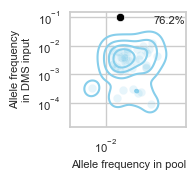

In [44]:
# The following is sub-optimal for several reasons, including because it needs to be adapted to any hotspot

sns.set(rc = {'figure.figsize':(1.5,1.5),
              'font.size':8,
              'legend.title_fontsize':8, 'legend.fontsize':8,
              'axes.labelsize':8,'axes.titlesize':8,
              'xtick.labelsize':8, 'ytick.labelsize':8,
              'xtick.major.pad':1, 'ytick.major.pad':1,
             },
       style='whitegrid')

fig = sns.scatterplot(corrdf[corrdf.Nham_aa_1p == 'non-WT'],
                      x='average_freq_pool', y='average_freq_input',
                      color='skyblue', alpha=.2,
                      legend=False)
sns.scatterplot(corrdf[corrdf.Nham_aa_1p == 'WT'],
                x='average_freq_pool', y='average_freq_input',
                color='black', legend=False)
sns.kdeplot(corrdf,x='average_freq_pool', y='average_freq_input',
            hue='Nham_aa_1p', hue_order=['WT','non-WT'], palette=['black','skyblue'], common_norm=False,
            levels=5, log_scale=True,legend=False)

fig.set(xscale='log', xlabel='Allele frequency in pool',
        yscale='log', ylabel='Allele frequency\nin DMS input',
        xlim=(None,5e-2) #7e-2for fks2-hs1, 5e-2 for fks2-hs2
       )
both_perc = ratios.loc[ratios.Location == 'both', 'aa_seq'].values[0] / unique_aa
fig.annotate(f'{both_perc:.1%}',(.72,.9), xycoords='axes fraction')

plt.savefig(f'{graph_outpath}/{"_".join([strain,locus,pool_type])}_bottleneck.svg', format='svg', dpi=300)

### Represented species in ortholog diversity

The following section does not currently support FKS2 hotspots

In [36]:
taxdf = pd.read_csv(orthoTAXpath, header=0)
taxdf

,Identifier,Species,Kingdom,Phylum,Hotspot1,Hotspot2,GapsHotspot1,GapsHotspot2,HS1_in_oPools,HS2_in_oPools,Is_Human_Pathogen
0,M!149570508_CHLRE,Chlamydomonas reinhardtii,Viridiplantae,Chlorophyta,AICSDLRED,QLGT----,False,True,True,False,False
1,M!114407260_ARATH,Arabidopsis thaliana,Viridiplantae,Streptophyta,LQVKPMIKP,GVILNQQF,False,False,True,True,False
2,M!114427513_ARATH,Arabidopsis thaliana,Viridiplantae,Streptophyta,LQIRPLIAP,NQQFIIQL,False,False,True,True,False
3,M!150549500_PHYBL,Phycomyces blakesleeanus,Fungi,Mucoromycota,FLALSFRDA,EWIQRCVL,False,False,True,True,False
4,M!85749882_RHIOR,Rhizopus oryzae,Fungi,Mucoromycota,FLALSFRDA,DWLQRCML,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...
226,M!104818385_545650,Sporothrix brasiliensis,Fungi,Ascomycota,YLTRAFRDS,DWVYRCIL,False,False,True,True,False
227,M!97086748_209285,Chaetomium thermophilum,Fungi,Ascomycota,YLTLSIRDP,DWIYRSVL,False,False,True,True,False
228,M!76899967_CHAGS,Chaetomium globosum,Fungi,Ascomycota,FLALSIRDP,DWVYRCIL,False,False,True,True,False
229,M!113676877_2587410,Thermothielavioides terrestris,Fungi,Ascomycota,YLTLSLRDP,DWVYRSVL,False,False,True,True,False


In [37]:
taxgby = taxdf.groupby('Hotspot'+locus[-1])[['Phylum','Kingdom','Species','Is_Human_Pathogen']
                                  ].agg(Kingdom = ('Kingdom', 'unique'),
                                        Phylum = ('Phylum', 'unique'),
                                        Nb_species = ('Species', 'nunique'),
                                        at_least_one_pathogen = ('Is_Human_Pathogen', 'any')
                                       ).reset_index()
taxgby

,Hotspot2,Kingdom,Phylum,Nb_species,at_least_one_pathogen
0,--------,[Fungi],"[Basidiomycota, Ascomycota]",2,False
1,AWVNRCIA,[Fungi],[Ascomycota],1,False
2,DWIDRCIA,[Fungi],[Ascomycota],1,False
3,DWIERCCV,[Fungi],[Ascomycota],1,False
4,DWIKRCIM,[Fungi],[Basidiomycota],1,False
...,...,...,...,...,...
92,QWVERCIV,[Fungi],[Ascomycota],1,False
93,QWVQRSIF,[Fungi],[Ascomycota],17,False
94,QWVQRSVL,[Fungi],[Ascomycota],1,False
95,RWIKRCII,[Fungi],[Basidiomycota],1,True


In [38]:
annotdf = pd.merge(left=corrdf, right=taxgby.rename(columns={'Hotspot'+locus[-1]:'aa_seq'}), on='aa_seq')
annotdf

,aa_seq,Nham_aa,confidence_score,inputO1,average_freq_pool,input1_abundance,input2_abundance,input3_abundance,average_freq_input,Location,Nham_aa_1p,Kingdom,Phylum,Nb_species,at_least_one_pathogen
0,AWVNRCIA,5.0,1.0,0.016938,0.016938,0.002310,0.000875,0.002032,0.001739,both,non-WT,[Fungi],[Ascomycota],1,False
1,DWIKRCIM,5.0,1.0,0.010996,0.010996,0.006020,0.002409,0.005151,0.004527,both,non-WT,[Fungi],[Basidiomycota],1,False
2,DWIKRCIV,5.0,1.0,0.014140,0.014140,0.000403,0.000139,0.000343,0.000295,both,non-WT,[Fungi],[Basidiomycota],2,False
3,DWIKRCVI,5.0,1.0,0.015028,0.015028,0.004254,0.001629,0.003428,0.003103,both,non-WT,[Fungi],[Basidiomycota],1,False
4,DWIRRCII,4.0,1.0,0.013576,0.013576,0.003348,0.001321,0.002976,0.002548,both,non-WT,[Fungi],"[Ascomycota, Basidiomycota]",3,False
5,DWIRRCIV,4.0,1.0,0.014780,0.014780,0.004995,0.001871,0.004545,0.003804,both,non-WT,[Fungi],[Basidiomycota],1,False
6,DWIRRCVL,3.0,1.0,0.027985,0.027985,0.005843,0.002261,0.004848,0.004317,both,non-WT,[Fungi],[Ascomycota],1,False
7,DWIRRYTL,1.0,1.0,0.011392,0.011392,0.003123,0.001417,0.002499,0.002346,both,non-WT,[Fungi],[Ascomycota],8,True
8,DWIYRCIV,5.0,1.0,0.012584,0.012584,0.000178,0.000082,0.000169,0.000143,both,non-WT,[Fungi],[Ascomycota],5,False
9,DWIYRCVL,4.0,1.0,0.025216,0.025216,0.017005,0.006476,0.014838,0.012773,both,non-WT,[Fungi],[Ascomycota],1,False


C:\Users\duran\AppData\Local\Temp\ipykernel_4820\1366991320.py:23: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(annotdf,x='average_freq_pool', y='average_freq_input',


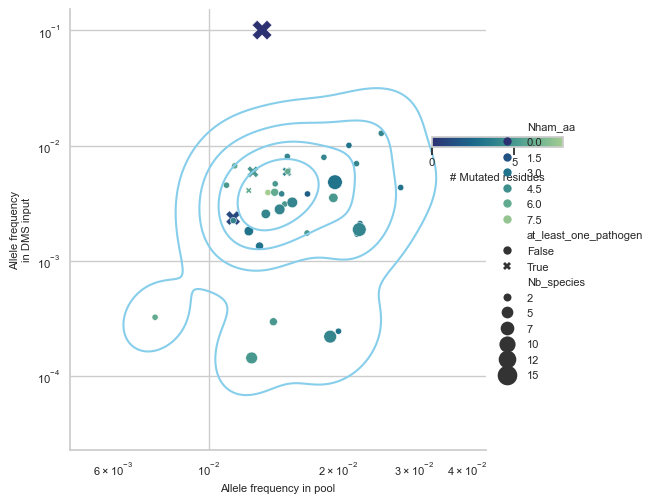

In [39]:
# The following is sub-optimal for several reasons, including because it needs to be adapted to any hotspot

# Setting up palette for number of mutated residues
Nham_norm = plt.Normalize(0, annotdf.Nham_aa.max())
sm = cm.ScalarMappable(cmap='crest_r', norm=Nham_norm)
sm.set_array([])

sns.set(rc = {#'figure.figsize':(1.9,1.9),
              'font.size':8,
              'legend.title_fontsize':8, 'legend.fontsize':8,
              'axes.labelsize':8,'axes.titlesize':8,
              'xtick.labelsize':8, 'ytick.labelsize':8,
              'xtick.major.pad':1, 'ytick.major.pad':1,
             },
       style='whitegrid')

fig = sns.relplot(annotdf, x='average_freq_pool', y='average_freq_input',
                  hue='Nham_aa', hue_order=sorted(annotdf.Nham_aa.unique()), palette='crest_r',
                  size='Nb_species', sizes=(20,200),
                  style='at_least_one_pathogen',
                  #height=1.9
                 )
sns.kdeplot(annotdf,x='average_freq_pool', y='average_freq_input',
            hue='Nham_aa_1p', hue_order=['WT','non-WT'], palette=['black','skyblue'], common_norm=False,
            levels=5, log_scale=True,legend=False)

fig.set(xscale='log', xlabel='Allele frequency in pool',
        #xlim=(5e-3,1e-1), #for hotspot1
        #xlim=(3e-3,3e-2),
        yscale='log', ylabel='Allele frequency\nin DMS input')

# Custom color bar for number of mutated residues
cax = plt.axes([0.67, 0.7, 0.2, 0.02]) # left bottom width height -- easy fix to prevent from stealing space to adjacent plot
cbar = plt.colorbar(sm, orientation='horizontal', cax=cax, label='# Mutated residues')
#cbar.ax.set_ylabel('# Mutated residues', rotation=0, loc='top')

#print(fig._legend.texts)
#for i, v in enumerate(['']*6+['Found in human pathogen', 'No', 'Yes', '# Species','6','12','18','24','30','36']):
#    fig._legend.texts[i].set_text(v)